In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PROCESS_NAME']='TTbar'

In [3]:
from analysis.processor import Processor

In [4]:
from analysis.custom import *

In [5]:
from config.selectionconfig import runsetting as rs

In [6]:
import random
import json

In [7]:
import awkward as ak
import dask_awkward as dak

In [8]:
import uproot

In [9]:
import sys

In [20]:
from analysis.spawndask import loadmeta, job, submitjobs

In [21]:
rs.TRANSFER_PATH='/store/user/joyzhou/vetoskim/TTbar'

In [22]:
loadmeta(0)['TTtoLNu2Q']['resumeindx']

[0,
 1,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187

## Unit test for Skim

In [13]:
test_skim()

Run: [ERROR] Local error: file exists:  (destination)

Delayed!
Cutflow written to local!


## Load skimmed events for some simple unit test

In [11]:
PREFIX = "root://cmseos.fnal.gov"

In [12]:
rs.DELAYED_OPEN=False
rs.COPY_LOCAL=False

In [13]:
proc = Processor(rs, 'ZH')

In [18]:
# filename = f"{PREFIX}//store/user/joyzhou/lepskim_hadded/ggF/GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00_1.root"
# filename = f"{PREFIX}//store/user/joyzhou/vetoskim_hadded/ggF/GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00_1.root"
filename = f"{PREFIX}//store/user/joyzhou/vetoskim_hadded/ZH/ZH_HToBB_ZToLL_M-125_1.root"

In [19]:
events = proc.loadfile(filename, 1)

In [20]:
type(events)

awkward.highlevel.Array

In [21]:
len(events)

12670

### Quick check that the events contain tau

In [18]:
genpartid = events['GenPart_pdgId']
motherid = events['GenPart_genPartIdxMother']

In [24]:
genpartmid = genpartid[motherid]

In [36]:
genpartid[0][25]

25

In [30]:
taumask = (abs(genpartid) == 15)
ak.sum(ak.sum(taumask, axis=-1) >= 1)

37483

In [37]:
motherid[taumask][1]

<Array [12, 12, 17, 16] type='4 * int16'>

In [32]:
genpartmid[taumask]

<Array [[25, 25], [25, 25, ..., 15], ..., [25, 25]] type='37483 * var * int32'>

In [19]:
bmask = (abs(genpartid) == 5)

In [20]:
ak.sum(ak.sum(bmask, axis=-1) >=1)

37483

In [31]:
fromHmask = (motherid == 25) | (motherid == 23)

In [32]:
ak.sum(ak.sum(taumask & fromHmask, axis=-1) >= 2)

573

In [38]:
# look at the first five cases
len(events[ak.sum(taumask & fromHmask, axis=-1)])

8319

In [29]:
events['GenPart_statusFlags'][taumask][0:5]

<Array [[12675, 12675], [...], ..., [12675, 12675]] type='5 * var * uint16'>

### Check methods on zipped obj

In [45]:
from analysis.selutility import Object

In [46]:
tau = Object(events, 'Tau')

In [47]:
def tauobjmask(tau):
    tau_mask = (tau.ptmask(opr.ge) & \
                tau.absetamask(opr.le) & \
                tau.absdzmask(opr.lt) & \
                tau.custommask('idvsjet', opr.ge))
    return tau_mask

tau_mask = tauobjmask(tau)
tau_nummask = tau.evtosmask(tau_mask)

events = events[tau_nummask]
tau.events = events
tau_mask = tauobjmask(tau)

# select two OS taus candidates
sorted_taus = tau.getzipped(mask=tau_mask)
leading_tau = sorted_taus[:,0]
subleading_cand = sorted_taus[:,1:]
os_mask = (subleading_cand['charge'] != leading_tau['charge'])
subleading_cand = subleading_cand[os_mask]

leading_lv = Object.fourvector(leading_tau, sort=False)
subleading_lvs = Object.fourvector(subleading_cand, sort=False)
dR_mask = Object.dRoverlap(leading_lv, subleading_lvs, threshold=0.5)

# make sure two candidates are separated enough
tau_nummask = Object.maskredmask(dR_mask, opr.ge, 1)
leading_tau = leading_tau[tau_nummask]
subleading_cand = subleading_cand[tau_nummask][:,0]

In [49]:
type(leading_tau)

dask_awkward.lib.core.Array

In [50]:
computedarr = leading_tau.compute()

In [53]:
df = ak.to_dataframe(computedarr)

### Investigate dask write

In [14]:
events = proc.evtsel(events)

In [15]:
proc.outdir

'/uscms/home/joyzhou/nobackup/outputs/ggF'

In [17]:
proc.writedask(events, 2, False)

Writing events!
Transferring to condorpath


### Investigate pair selections

In [244]:
## Test below
tau_charge = events['Tau_charge']
tau_pt = events['Tau_pt']
sum_charge = abs(ak.sum(tau_charge, axis=1))
mask = (sum_charge < ak.num(tau_charge, axis=1))

In [245]:
charge_bit = tau_charge > 0

In [246]:
negative_bit = tau_charge < 0

In [247]:
pt_bit = tau_pt > 50

In [249]:
# calculate after pt cut
ak.sum(ak.sum(pt_bit, axis=1) >= 2)

12976

In [255]:
osmask = ak.any(pt_bit & negative_bit, axis=1) & ak.any(pt_bit & charge_bit, axis=1)

In [258]:
ak.sum(osmask)

11728

In [266]:
tau_pt_cut = tau_charge[pt_bit]
tau_pt_cut_pt = tau_pt[pt_bit]

In [277]:
# old mask
oldmask = abs(ak.sum(tau_pt_cut, axis=1)) < ak.num(tau_pt_cut, axis=1)

## Investigate Dask Performance 

In [11]:
data = loadmeta()

In [12]:
data

{'ZZto4L': {'resumeindx': [46,
   105,
   113,
   214,
   254,
   255,
   272,
   276,
   298,
   308,
   310,
   328,
   333,
   341,
   348,
   373,
   383,
   385,
   386,
   401,
   407,
   410],
  'filelist': ['root://cmsxrootd.fnal.gov//store/mc/Run3Summer22EENanoAODv11/ZZto4L_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/126X_mcRun3_2022_realistic_postEE_v1-v2/80000/35975bed-5d4c-41ab-8ff2-9d935694d696.root',
   'root://cmsxrootd.fnal.gov//store/mc/Run3Summer22EENanoAODv11/ZZto4L_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/126X_mcRun3_2022_realistic_postEE_v1-v2/80000/be273cd8-c9f6-47d6-9240-924a597ef4d8.root',
   'root://cmsxrootd.fnal.gov//store/mc/Run3Summer22EENanoAODv11/ZZto4L_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/126X_mcRun3_2022_realistic_postEE_v1-v2/80000/9e24018b-7dec-457b-86f3-5b6063b4b9d0.root',
   'root://cmsxrootd.fnal.gov//store/mc/Run3Summer22EENanoAODv11/ZZto4L_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/126X_mcRun3_2022_realistic_postEE_v1-v2/80000/072fb780-fd1f-4c

In [16]:
data.keys()

dict_keys(['ZZto4L', 'ZZto2L2Nu', 'ZZto2Nu2Q', 'ZZto2L2Q'])

In [13]:
from analysis.spawndask import spawnLocal

In [14]:
client = spawnLocal()

/uscms/home/joyzhou/nobackup/newcoffea_el9/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41859 instead
  warnings.warn(


successfully created a dask client in local cluster!
<Client: 'tcp://127.0.0.1:44517' processes=2 threads=8, memory=11.42 GiB>


In [15]:
client

<Client: 'tcp://127.0.0.1:44517' processes=2 threads=8, memory=11.42 GiB>

In [17]:
proc = Processor(rs, 'ZZto4L', switch_selections(rs.SEL_NAME))

In [19]:
events = proc.loadfile(data['ZZto4L']['filelist'][46], 46)

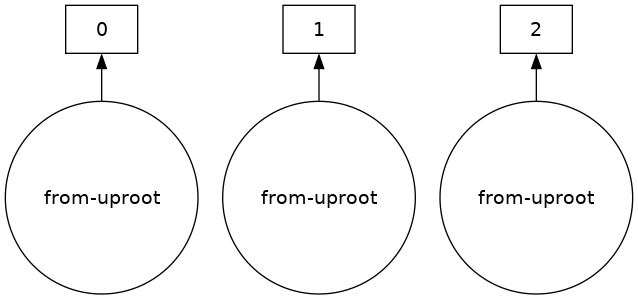

In [21]:
events.visualize()

In [15]:
# Run two files concurrently
file1 = data['GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00']['filelist'][0]
file2 = data['GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00']['filelist'][1]

In [16]:
rs.COPY_LOCAL = False
rs.STEP_SIZE = '140MB'

In [35]:
# Try a large dataset


In [28]:
events = proc.loadfile(file2, 2)

In [33]:
events = proc.evtsel(events)

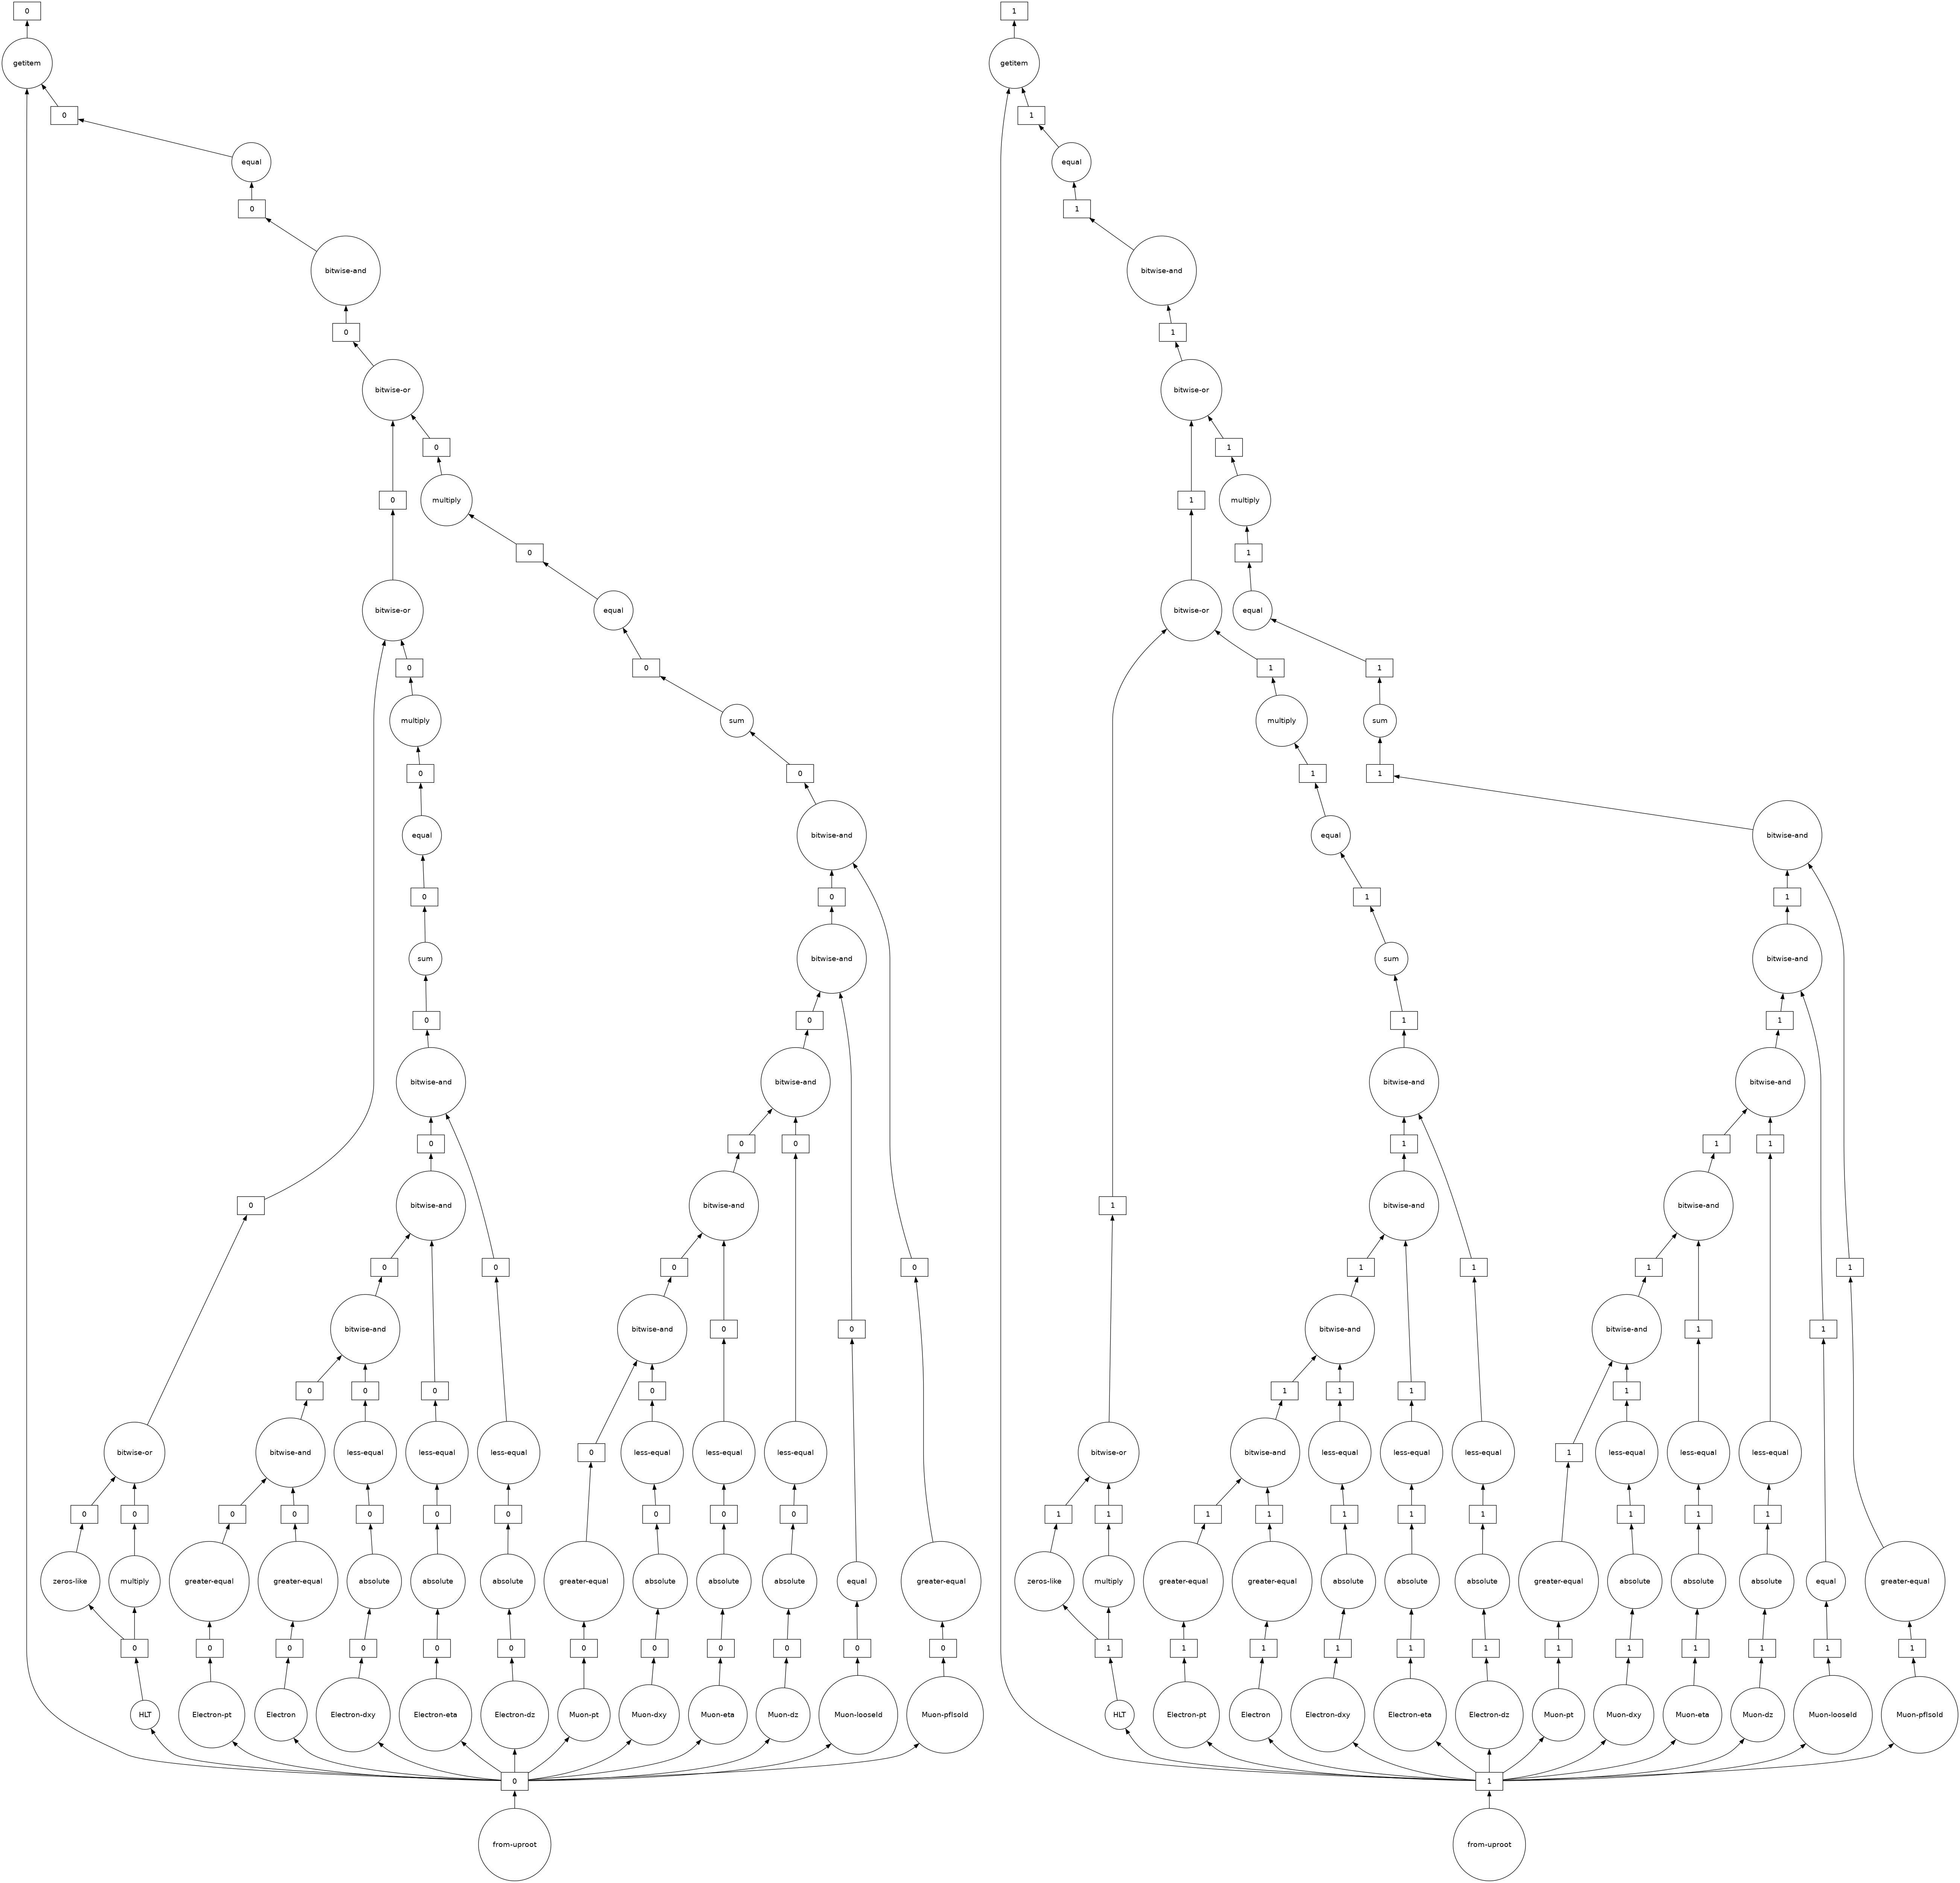

In [34]:
events.visualize()

In [31]:
# test map_partitions
dak.map_partitions(proc.evtsel.setevtsel, events)

TypeError: map_partitions expects at least one Dask collection instance, you are passing non-Dask collections to dask-awkward code.
observed argument types:
- <class 'awkward.highlevel.Array'>

In [36]:
proc.runfile(file2, 2)


Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-centos8-gcc11-opt/lib/python3.9/site-packages/distributed/utils.py", line 803, in wrapper
    return await func(*args, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-centos8-gcc11-opt/lib/python3.9/site-packages/distributed/worker.py", line 1508, in close
    await self.finished()
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-centos8-gcc11-opt/lib/python3.9/site-packages/distributed/core.py", line 592, in finished
    await self._event_finished.wait()
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos8-gcc11-opt/lib/python3.9/asyncio/locks.py", line 226, in wait
    await fut
asyncio.exceptions.CancelledError
Timed out during handshake while connecting to tcp://127.0.0.1:39135 after 30 s
Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-centos8-gcc11-opt/lib/python3.9/site-packages/tornado/iostream.py", line 867, in _re

'file root://cmsxrootd.fnal.gov//store/mc/Run3Summer22EENanoAODv12/GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_postEE_v6-v3/80000/d76d5b20-9372-4f12-81af-205c7acbcd70.root processed successfully!'

In [35]:
# manually trim memory
import ctypes

def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

client.run(trim_memory)

{'tcp://127.0.0.1:34715': 1}

In [36]:
import tracemalloc 
tracemalloc.start() 

In [37]:
snapshot = tracemalloc.take_snapshot() 
top_stats = snapshot.statistics('lineno') 
  
for stat in top_stats[:10]: 
   print(stat)

/cvmfs/sft.cern.ch/lcg/views/LCG_104/x86_64-centos8-gcc11-opt/lib/python3.9/site-packages/dask/base.py:1136: size=7313 KiB, count=1, average=7313 KiB
/uscms/home/joyzhou/nobackup/coffeajup/lib/python3.9/site-packages/uproot/model.py:778: size=4787 KiB, count=65018, average=75 B
/uscms/home/joyzhou/nobackup/coffeajup/lib/python3.9/site-packages/uproot/source/cursor.py:49: size=3560 KiB, count=70065, average=52 B
/uscms/home/joyzhou/nobackup/coffeajup/lib/python3.9/site-packages/uproot/model.py:857: size=3398 KiB, count=20714, average=168 B
/uscms/home/joyzhou/nobackup/coffeajup/lib/python3.9/site-packages/uproot/source/cursor.py:116: size=2772 KiB, count=41917, average=68 B
/uscms/home/joyzhou/nobackup/coffeajup/lib/python3.9/site-packages/uproot/model.py:782: size=2031 KiB, count=32502, average=64 B
/uscms/home/joyzhou/nobackup/coffeajup/lib/python3.9/site-packages/uproot/model.py:783: size=1776 KiB, count=32470, average=56 B
/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-c

In [38]:
!pip install guppy3

^C


In [22]:
import cProfile

In [30]:
# inspect task graph to see if there's inefficiency
passed = proc.evtsel(events)

TypeError: Converting from an nplike without known data to an nplike with known data is not supported

This error occurred while calling

    ak.to_numpy(
        <Array-typetracer [...] type='## * bool'>
        allow_missing = True
    )

In [ ]:
passed.visualize()

In [27]:
future1 = client.submit(job, file1, 1, 'ggF')
future2 = client.submit(job, file2, 2, 'ggF')

In [29]:
type(future1)

distributed.client.Future

In [28]:
client.gather([future1, future2])

[False, False]

## Inspect a skimmed file and run custom selections

In [50]:
filename = 'GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00_1-part0.root'
dirname = '/uscms/home/joyzhou/nobackup/output/ggF'
proc = Processor(rs, 'ggF', prelimEvtSel)

In [51]:
evts = proc.loadfile(pjoin(dirname, filename), 0)
# Do something after this cell to conduct inspection

In [53]:
proc.runfile(pjoin(dirname, filename), 0)

'file /uscms/home/joyzhou/nobackup/output/ggF/GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00_1-part0.root processed successfully!'

In [54]:
result = pjoin('/uscms/home/joyzhou/nobackup/tests', 'ggF_0-part0.root')
fit_evts = proc.loadfile(result, 'test')

## Run over example files

In [9]:
# custom-define datasets to process 
process_names = ["TTbar", "ggF", "SingleH"]
data_src = 'src/data/preprocessed'

In [9]:
# Quick hack
ds_names = ["DYJets", "TTbar", "ggF"]
filelist = ["root://cmsxrootd.fnal.gov//store/mc/Run3Winter22NanoAOD/DYJetsToLL_M-10to50_TuneCP5_13p6TeV-madgraphMLM-pythia8/NANOAODSIM/122X_mcRun3_2021_realistic_v9-v1/30000/10e16df1-d8bb-4b32-bb90-32c4fd57f429.root",
           "root://cmsxrootd.fnal.gov//store/mc/Run3Summer22EENanoAODv12/TTto2L2Nu_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_postEE_v6-v2/2540000/62aea484-cae5-4c41-8803-08969f44c116.root",
           "root://cmsxrootd.fnal.gov//store/mc/Run3Summer22EENanoAODv12/GluGlutoHHto2B2Tau_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_postEE_v6-v3/80000/5998ad11-ab82-41bf-a740-7a2c38b85a14.root"]

In [10]:
finame = filelist[1]
proc = Processor(rs, 'TTbar')

In [18]:
events = proc.loadfile(finame, 'test')

In [36]:
proc.outdir

'/uscms/home/joyzhou/nobackup/tests'

In [37]:
proc = Processor(rs, 'TTbar', mockskimEvtSel)

In [ ]:
# examine the file later
proc.runfile()

In [17]:
# create an object mask
tau_mask = (events['Tau_pt'] > 25) & (abs(events['Tau_eta']) < 3.0)

In [9]:
for i, ds in enumerate(ds_names):
    proc = Processor(rs, ds)
    proc.runfile(filelist[i], 0, None)

In [15]:
output_fi = os.listdir(rs.OUTPUTDIR_PATH)

In [21]:
dfs = []
for file_name in output_fi:
    df = pd.read_csv(pjoin(rs.OUTPUTDIR_PATH, file_name), index_col=0, header=0)
    df.columns = [file_name]
    dfs.append(df)

In [22]:
raw_df = pd.concat(dfs, axis=1)

In [23]:
raw_df

DYJets_cutflow_0.csv  TTbar_cutflow_0.csv  \
initial                          506334               927960   
ElectronSelection                500522               525938   
MuonSelection                    488033               289438   
TauSelection                        361                32286   

                   ggF_cutflow_0.csv  
initial                        80104  
ElectronSelection              45205  
MuonSelection                  31124  
TauSelection                   14806

In [24]:
efficiency_df = raw_df.div(raw_df.shift(1)).fillna(1)

In [25]:
# incremental
efficiency_df

DYJets_cutflow_0.csv  TTbar_cutflow_0.csv  \
initial                        1.000000             1.000000   
ElectronSelection              0.988521             0.566768   
MuonSelection                  0.975048             0.550327   
TauSelection                   0.000740             0.111547   

                   ggF_cutflow_0.csv  
initial                     1.000000  
ElectronSelection           0.564329  
MuonSelection               0.688508  
TauSelection                0.475710

In [26]:
overall_eff = raw_df.div(raw_df.iloc[0]).fillna(1)

In [27]:
# wrt to total
overall_eff

DYJets_cutflow_0.csv  TTbar_cutflow_0.csv  \
initial                        1.000000             1.000000   
ElectronSelection              0.988521             0.566768   
MuonSelection                  0.963856             0.311908   
TauSelection                   0.000713             0.034792   

                   ggF_cutflow_0.csv  
initial                     1.000000  
ElectronSelection           0.564329  
MuonSelection               0.388545  
TauSelection                0.184835

In [ ]:
# Run small scale selections on one file for each process
def runsample(dsnames, datasrc):
    samplefl = []
    for name in dsnames:
        with open(pjoin(datasrc, f'{name}.json'), 'r') as file:
            meta = json.load(file)
            samplefl.append(meta)